# PROJECT FUTBIZZ (PART 2)

# RECOMMENDATION MODEL
In this we recommend differnt players based attributes like team , age , number of recommended players and position. We consider these attributes more important as the different teams require different players(for example - we cannot replace ronaldo with another player similar to ronaldo as there is only one ronaldo). Our aim is to replace a player that matches the team style and position.We have engineered  the data in depth and relevant changes have been made so that our model would able to recommend a player best suited for the club.

MODEL USED: KNN
The K-Nearest Neighbours (K-NN) is a machine learning algorithm that is applied in classification and regression.The final output in this algorithm is based on the K nearest data elements of a new data element in the space.In classification, the class label for a new data point is the most common class the K nearest neighbouring data points belong to.In regression, the output value for a new instance is the mean of the values of K nearest neighbouring data points.

### IMPORTING LIBRARIES

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
%matplotlib inline
import warnings
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import pickle
import os
from plotly.offline import init_notebook_mode, iplot, plot
from plotly.subplots import make_subplots
import plotly.express as px
import plotly as py
init_notebook_mode(connected=True)
import plotly.graph_objs as go
from math import pi
from matplotlib.pyplot import cm

In [2]:
df=pd.read_csv("FIFA19_data1.csv")
df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


### FINDING MISSING VALUES

In [3]:
#Checking dataset for NA values
total_num = df.isnull().sum().sort_values(ascending=False)

perc = df.isnull().sum()/df.isnull().count() *100
perc1 = (round(perc,2).sort_values(ascending=False))

# Creating a data frame:
fifa_null = pd.concat([total_num, perc1], axis =1 , keys =["Total Missing Values", "Percentage %"]).sort_values(by ="Percentage %", ascending = False)

#Top nulls
top_null = fifa_null[fifa_null["Percentage %"]>0]
top_null.reset_index(inplace=True)
top_null.columns = ['index', "Total Missing Values", "Percentage %"]
top_null.head(10)

,index,Total Missing Values,Percentage %
0,Loaned From,16943,93.06
1,RAM,2085,11.45
2,LS,2085,11.45
3,ST,2085,11.45
4,RS,2085,11.45
5,LW,2085,11.45
6,LF,2085,11.45
7,CF,2085,11.45
8,RF,2085,11.45
9,RW,2085,11.45


Text(0.5, 1, 'Missing Values by column')

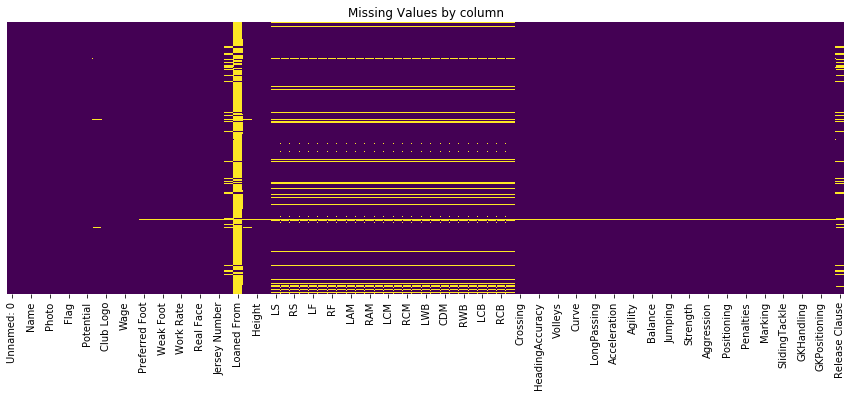

In [4]:
plt.figure(figsize=(15,5))
sns.heatmap(df.isnull(), cbar = False, yticklabels=False, cmap="viridis" )
plt.title('Missing Values by column')

### DROPPING UNNECESSERAY COLUMNS

In [5]:
#Drop some columns
fifa = df.drop(['ID', 'Photo', 'Flag', 'Club Logo'], axis = 1)
fifa.replace('nan',np.nan, inplace=True)

In [6]:
#Rename unamed to ID
fifa = fifa.rename({'Unnamed: 0' : 'ID'}, axis = 1)

### CONVERTING VALUE, RELEASE CLAUSE AND WAGE TO NORMALIZED VALUES

In [7]:
# The value has some non numeric mark so I extract rigth value
def value_to_int(df_value):
    try:
        value = float(df_value[1:-1])
        suffix = df_value[-1:]

        if suffix == 'M':
            value = value * 1000000
        elif suffix == 'K':
            value = value * 1000
    except ValueError:
        value = 0
    return value

#Create float Value column
fifa['Value'] = fifa['Value'].apply(value_to_int)

#Create float Wage Column
fifa['Wage'] = fifa['Wage'].apply(value_to_int)


#Create float Wage Column
fifa['Release Clause'] = fifa['Release Clause'].astype(str)
fifa['Release Clause'] = fifa['Release Clause'].apply(value_to_int)


print(fifa['Value'].head())
print(fifa['Wage'].head())
print(fifa['Release Clause'].head())

0    110500000.0
1     77000000.0
2    118500000.0
3     72000000.0
4    102000000.0
Name: Value, dtype: float64
0    565000.0
1    405000.0
2    290000.0
3    260000.0
4    355000.0
Name: Wage, dtype: float64
0    226500000.0
1    127100000.0
2    228100000.0
3    138600000.0
4    196400000.0
Name: Release Clause, dtype: float64


### DATA ENGINEERING ON CATEGORICAL VALUES 

we engineer to fill the null values in the columns and make more meaningful data.

In [8]:
#Left foot = 0 Right foot = 1
fifa['Preferred Foot'] = fifa['Preferred Foot'].apply(lambda x: 0 if x == 'Left' else 1)

In [9]:
fifa['Club'] = fifa['Club'].fillna('No_Club')

In [10]:
#Add club reputation column
fifa['Club_Reputation'] =  fifa['International Reputation'].groupby(fifa['Club']).transform('mean')


In [11]:
#Work Rate
fifa['Work Rate'] = fifa['Work Rate'].astype(str)

split_wr = fifa['Work Rate'].str.split('/', n=1, expand = True)

#Create attack/defense work rate from Work rate and drop wr
fifa['Attack_WR'] = split_wr[0]
fifa['Defense_WR'] = split_wr[1]
fifa = fifa.drop('Work Rate', axis = 1)

fifa['Defense_WR'] = fifa['Defense_WR'].str.strip()

In [12]:
#Fill in miscellaneous body types 
fifa['Body Type'].replace({'Messi':'Lean', 
                           'Neymar':'Lean', 
                           'Shaqiri':'Stocky', 
                           'Courtois':'Normal', 
                           'Akinfenwa':'Stocky',
                           'PLAYER_BODY_TYPE_25':'Lean',
                           'C. Ronaldo':'Normal'}, inplace = True)


In [13]:
#Drop rows with missing Body Type - these values also are missing most other columns
fifa.dropna(subset=['Body Type'], inplace = True)

In [14]:
#Real Face: Yes = 1 No = 0
fifa['Real Face'] = fifa['Real Face'].apply(lambda x: 1 if x == 'Yes' else 0)

In [15]:
#Define position groups
forwards = ['RF', 'ST', 'LW','LF', 'RS', 'LS', 'RW', 'CF' ]
defenders = ['RCB','CB', 'LCB', 'LB', 'RB', 'RWB', 'LWB']
mids = ['RCM', 'LCM', 'LDM', 'CAM', 'CDM', 'RM', 'LAM', 'LM', 'RDM', 'CM', 'RAM']
gk = ['GK']

#Create Function to apply to df
def label_position(row):
    if row['Position'] in forwards:
        return 'Forward'
    if row['Position'] in defenders:
        return 'Defender'
    if row['Position'] in mids:
        return 'Midfielder'
    if row['Position'] in gk:
        return 'GoalKeeper'
    return 'Other'

#Create Position_group column of 4 Main positions
fifa['Position_Group'] = fifa.apply(lambda row: label_position(row), axis = 1)

#Turn it into categorical variable 
fifa['Position_Group'] = fifa['Position_Group'].astype('category')

In [16]:
import datetime
from datetime import date, timedelta
fifa['Joined'] = pd.to_datetime(fifa['Joined'], format = '%b %d, %Y')

#Keep only the date 
fifa['Joined'] = fifa['Joined'].dt.date

fifa['Joined'] = [datetime.date(2019, 1, 1) - x for x in fifa['Joined']]

fifa['Joined'] = fifa['Joined'].astype(str)

fifa['Joined'] = fifa.Joined.str.split("days").apply(lambda x: x[0])

fifa['Joined'] = fifa['Joined'].replace('NaT', '0')

fifa['Joined'] = fifa['Joined'].astype(float)

In [17]:
#Binary - loan or not
fifa.set_value(fifa.index[~fifa['Loaned From'].isnull()],'Loaned From', 1)
fifa.set_value(fifa.index[fifa['Loaned From'].isnull()],'Loaned From', 0)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning:

set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning:

set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead



,ID,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,...,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause,Club_Reputation,Attack_WR,Defense_WR,Position_Group
0,0,L. Messi,31,Argentina,94,94,FC Barcelona,110500000.0,565000.0,2202,...,6.0,11.0,15.0,14.0,8.0,226500000.0,2.242424,Medium,Medium,Forward
1,1,Cristiano Ronaldo,33,Portugal,94,94,Juventus,77000000.0,405000.0,2228,...,7.0,11.0,15.0,14.0,11.0,127100000.0,2.520000,High,Low,Forward
2,2,Neymar Jr,26,Brazil,92,93,Paris Saint-Germain,118500000.0,290000.0,2143,...,9.0,9.0,15.0,15.0,11.0,228100000.0,2.233333,High,Medium,Forward
3,3,De Gea,27,Spain,91,93,Manchester United,72000000.0,260000.0,1471,...,90.0,85.0,87.0,88.0,94.0,138600000.0,2.090909,Medium,Medium,GoalKeeper
4,4,K. De Bruyne,27,Belgium,91,92,Manchester City,102000000.0,355000.0,2281,...,15.0,13.0,5.0,10.0,13.0,196400000.0,2.090909,High,High,Midfielder
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18202,18202,J. Lundstram,19,England,47,65,Crewe Alexandra,60000.0,1000.0,1307,...,10.0,13.0,7.0,8.0,9.0,143000.0,1.035714,Medium,Medium,Midfielder
18203,18203,N. Christoffersson,19,Sweden,47,63,Trelleborgs FF,60000.0,1000.0,1098,...,10.0,9.0,9.0,5.0,12.0,113000.0,1.000000,Medium,Medium,Forward
18204,18204,B. Worman,16,England,47,67,Cambridge United,60000.0,1000.0,1189,...,6.0,5.0,10.0,6.0,13.0,165000.0,1.000000,Medium,Medium,Forward
18205,18205,D. Walker-Rice,17,England,47,66,Tranmere Rovers,60000.0,1000.0,1228,...,14.0,6.0,14.0,8.0,9.0,143000.0,1.000000,Medium,Medium,Forward


In [18]:
#Change Contract Valid Until to the years from 2018 

fifa['Contract Valid Until'] = fifa['Contract Valid Until'].astype(str)

fifa['Contract Valid Until'] = [x[-4:] for x in fifa['Contract Valid Until']]

fifa['Contract Valid Until'] = fifa['Contract Valid Until'].replace({'nan': '2018'})

fifa['Contract Valid Until'] = fifa['Contract Valid Until'].astype(float) - 2018

In [19]:
#Convert height from feet'inches to centimeters

def parse_ht(ht):
    # format: 7'0
    ht_ = ht.split("'")
    ft_ = int(ht_[0])
    in_ = int(ht_[1])
    return round(((12*ft_) + in_)*2.54) 
  
fifa['Height'] = fifa['Height'].apply(lambda x:parse_ht(x))

In [20]:
fifa['Weight'] = fifa['Weight'].astype(str).str.replace('lbs', '').astype(float)

In [21]:
fifa['Position_Potential'] = fifa['LS']

def potential(x):
    x = str(x)
    if('+' in x):
        calc = x.split('+')
        return int(calc[1])
    else:
        return int(0)

fifa['Position_Potential'] = fifa['Position_Potential'].apply(potential)

fifa['Position_Potential'].head()

0    2
1    3
2    3
3    0
4    3
Name: Position_Potential, dtype: int64

In [22]:
#Get rid of the +int at the end of the position overall columns
def get_rid(x):
    x = str(x)
    if('+' in x):
        calc = x.split('+')
        return int(calc[0])
    elif x.isdigit():
        return int(x)
    else:
        return int(0)


for column in fifa.loc[:,'LS':'RB']:
    fifa[column] = fifa[column].apply(get_rid)

In [23]:
#Create the attribute group mean columns
fifa['Attacking'] = fifa.loc[:,'Crossing':'Volleys'].mean(axis=1)
fifa['Skill'] = fifa.loc[:,'Dribbling':'BallControl'].mean(axis=1)
fifa['Movement'] = fifa.loc[:,'Acceleration':'Balance'].mean(axis=1)
fifa['Power'] = fifa.loc[:,'ShotPower':'LongShots'].mean(axis=1)
fifa['Mentality'] = fifa.loc[:,'Aggression':'Composure'].mean(axis=1)
fifa['Defending'] = fifa.loc[:,'Marking':'SlidingTackle'].mean(axis=1)
fifa['GoalKeeping'] = fifa.loc[:,'GKDiving':'GKReflexes'].mean(axis=1)

In [24]:
#Fill in the empty Position values based on the players' max ability

for index, row in fifa.loc[fifa['Position_Group'] == 'Other', ['Attacking', 'Defending', 'GoalKeeping']].iterrows():
    if (row[0] > row[1]) & (row[0] > row[2]):
        fifa.loc[index, 'Position'] = 'ST'
    elif (row[1] > row[0]) & (row[1] > row[2]):
        fifa.loc[index, 'Position'] = 'CB'
    elif(row[2] > row[0]) & (row[2] > row[1]):
        fifa.loc[index, 'Position'] = 'GK'
    else:
        fifa.loc[index, 'Position'] = 'CM'

In [25]:
#Fill Jersey Number with mode from their position

for index, row in fifa.loc[fifa['Position_Group'] == 'Other', ['Position', 'Jersey Number']].iterrows():
    if row[0] == 'CB':
        fifa.loc[index, 'Jersey Number'] = float(fifa[fifa['Position'] == 'CB']['Jersey Number'].mode().values)
    elif row[0] == 'ST':
        fifa.loc[index, 'Jersey Number'] = float(fifa[fifa['Position'] == 'ST']['Jersey Number'].mode().values)
    elif row[0] == 'GK':
        fifa.loc[index, 'Jersey Number'] = float(fifa[fifa['Position'] == 'GK']['Jersey Number'].mode().values)
    else:
        fifa.loc[index, 'Jersey Number'] = float(fifa[fifa['Position'] == 'CM']['Jersey Number'].mode().values)


In [26]:
#Fill their Position_Group for these new imputed positions

#Create Position_group column of 4 Main positions
fifa['Position_Group'] = fifa.apply(lambda row: label_position(row), axis = 1)

#Turn it into categorical variable 
fifa['Position_Group'] = fifa['Position_Group'].astype('category')

In [27]:
#Create Potential - Difference column to measure improvement potential
fifa['Potential_Difference'] = fifa['Potential'] - fifa['Overall']

In [28]:
countries_cont = pd.read_csv("coun_by_cont.csv")
fifa = fifa.merge(countries_cont, how = 'left', left_on = 'Nationality', right_on = 'Country')

fifa = fifa.drop('Country', axis = 1)

In [29]:
#Find mean wage by overall quartiles
wage_groups = fifa.groupby(pd.qcut(fifa['Overall'],4)).mean()['Wage']

#Fill the 0 wages with group mean
for index, row in fifa.loc[fifa['Wage'] == 0, ['Wage', 'Overall']].iterrows():
    if row[1] <= 62:
        fifa.loc[index, 'Wage'] = round(wage_groups[0])
    elif (row[1] >62) &  (row[1] <= 66):
        fifa.loc[index, 'Wage'] = round(wage_groups[1])
    elif (row[1] > 66) &  (row[1] <= 71):
        fifa.loc[index, 'Wage'] = round(wage_groups[2])
    elif row[1] >71:
        fifa.loc[index, 'Wage'] = round(wage_groups[3])
    else:
        fifa.loc[index, 'Wage'] = 0

In [30]:
#DROP these columns first
drop_cols = ['ID', 'Name','Nationality','Club']
numeric_cols = list(fifa.dtypes[(fifa.dtypes == 'float64')|(fifa.dtypes == 'int64')].index)

#Dummy Predictors
fifa_dumm_cols = fifa.loc[:, ['Position', 'Continent', 'Position_Group']]

#Ordinal Predictors
fifa_ordinal_cols = fifa.loc[:, ['Body Type', 'Attack_WR', 'Defense_WR']]

#Numerical Predictors
fifa_numeric_cols = fifa[numeric_cols]
fifa_numeric_cols = fifa_numeric_cols.drop(['ID', 'Wage','Value','Release Clause'], axis = 1)

In [31]:
#Getting dummy dataframe for nominal variables
dummy_df = pd.get_dummies(fifa_dumm_cols)

#Mapping ordinal column values
b_type_map = {"Lean": 1, "Normal": 2, "Stocky": 3}
wr_map = {"Low": 1, "Medium": 2, "High": 3}

fifa_ordinal_cols['Body Type'] = fifa_ordinal_cols['Body Type'].map(b_type_map)
fifa_ordinal_cols['Attack_WR'] = fifa_ordinal_cols['Attack_WR'].map(wr_map)
fifa_ordinal_cols['Defense_WR'] = fifa_ordinal_cols['Defense_WR'].map(wr_map)

In [32]:
name_cols = fifa.dtypes[(fifa.dtypes == 'object')|(fifa.dtypes == 'category')]
name_cols

Name                object
Nationality         object
Club                object
Body Type           object
Position            object
Attack_WR           object
Defense_WR          object
Position_Group    category
Continent           object
dtype: object

In [33]:
print(fifa_ordinal_cols.shape)
print(dummy_df.shape)
print(fifa_numeric_cols.shape)
print(fifa.shape)

(18159, 3)
(18159, 37)
(18159, 85)
(18159, 98)


In [34]:
predictors_df = pd.concat([fifa_numeric_cols,fifa_ordinal_cols, dummy_df], axis=1) 

In [35]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
predictors_df.shape

(18159, 125)

### FINAL DATASETS

In [36]:
predictors_df.head()

,Age,Overall,Potential,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Real Face,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Club_Reputation,Position_Potential,Attacking,Skill,Movement,Power,Mentality,Defending,GoalKeeping,Potential_Difference,Body Type,Attack_WR,Defense_WR,Position_CAM,Position_CB,Position_CDM,Position_CF,Position_CM,Position_GK,Position_LAM,Position_LB,Position_LCB,Position_LCM,Position_LDM,Position_LF,Position_LM,Position_LS,Position_LW,Position_LWB,Position_RAM,Position_RB,Position_RCB,Position_RCM,Position_RDM,Position_RF,Position_RM,Position_RS,Position_RW,Position_RWB,Position_ST,Continent_Africa,Continent_Asia,Continent_Europe,Continent_North America,Continent_Oceania,Continent_South America,Position_Group_Defender,Position_Group_Forward,Position_Group_GoalKeeper,Position_Group_Midfielder
0,31,94,94,2202,0,5.0,4.0,4.0,1,10.0,5297.0,0,3.0,170,159.0,88,88,88,92,93,93,93,92,93,93,93,91,84,84,84,91,64,61,61,61,64,59,47,47,47,59,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,2.242424,2,85.0,93.4,91.6,75.6,71.500000,29.000000,10.8,0,1,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
1,33,94,94,2228,1,5.0,4.0,5.0,1,7.0,175.0,0,4.0,188,183.0,91,91,91,89,90,90,90,89,88,88,88,88,81,81,81,88,65,61,61,61,65,61,53,53,53,61,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,2.520000,3,87.0,83.2,86.6,90.0,74.833333,27.333333,11.6,0,2,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0
2,26,92,93,2143,1,5.0,5.0,5.0,1,10.0,516.0,0,4.0,175,150.0,84,84,84,89,89,89,89,89,89,89,89,88,81,81,81,88,65,60,60,60,65,60,47,47,47,60,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,2.233333,3,79.2,88.8,91.6,70.6,73.833333,28.000000,11.8,1,1,3,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
3,27,91,93,1471,1,4.0,3.0,1.0,1,1.0,2741.0,0,2.0,193,168.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,2.090909,0,22.8,30.2,61.6,43.4,42.666667,16.333333,88.8,2,1,2,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4,27,91,92,2281,1,4.0,5.0,4.0,1,7.0,1220.0,0,5.0,180,154.0,82,82,82,87,87,87,87,87,88,88,88,88,87,87,87,88,77,77,77,77,77,73,66,66,66,73,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,2.090909,3,80.8,87.2,80.2,82.0,80.833333,59.000000,11.2,1,2,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


In [37]:
fifa.head()

,ID,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Body Type,Real Face,Position,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause,Club_Reputation,Attack_WR,Defense_WR,Position_Group,Position_Potential,Attacking,Skill,Movement,Power,Mentality,Defending,GoalKeeping,Potential_Difference,Continent
0,0,L. Messi,31,Argentina,94,94,FC Barcelona,110500000.0,565000.0,2202,0,5.0,4.0,4.0,Lean,1,RF,10.0,5297.0,0,3.0,170,159.0,88,88,88,92,93,93,93,92,93,93,93,91,84,84,84,91,64,61,61,61,64,59,47,47,47,59,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,226500000.0,2.242424,Medium,Medium,Forward,2,85.0,93.4,91.6,75.6,71.500000,29.000000,10.8,0,South America
1,1,Cristiano Ronaldo,33,Portugal,94,94,Juventus,77000000.0,405000.0,2228,1,5.0,4.0,5.0,Normal,1,ST,7.0,175.0,0,4.0,188,183.0,91,91,91,89,90,90,90,89,88,88,88,88,81,81,81,88,65,61,61,61,65,61,53,53,53,61,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,127100000.0,2.520000,High,Low,Forward,3,87.0,83.2,86.6,90.0,74.833333,27.333333,11.6,0,Europe
2,2,Neymar Jr,26,Brazil,92,93,Paris Saint-Germain,118500000.0,290000.0,2143,1,5.0,5.0,5.0,Lean,1,LW,10.0,516.0,0,4.0,175,150.0,84,84,84,89,89,89,89,89,89,89,89,88,81,81,81,88,65,60,60,60,65,60,47,47,47,60,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,228100000.0,2.233333,High,Medium,Forward,3,79.2,88.8,91.6,70.6,73.833333,28.000000,11.8,1,South America
3,3,De Gea,27,Spain,91,93,Manchester United,72000000.0,260000.0,1471,1,4.0,3.0,1.0,Lean,1,GK,1.0,2741.0,0,2.0,193,168.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,138600000.0,2.090909,Medium,Medium,GoalKeeper,0,22.8,30.2,61.6,43.4,42.666667,16.333333,88.8,2,Europe
4,4,K. De Bruyne,27,Belgium,91,92,Manchester City,102000000.0,355000.0,2281,1,4.0,5.0,4.0,Normal,1,RCM,7.0,1220.0,0,5.0,180,154.0,82,82,82,87,87,87,87,87,88,88,88,88,87,87,87,88,77,77,77,77,77,73,66,66,66,73,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,196400000.0,2.090909,High,High,Midfielder,3,80.8,87.2,80.2,82.0,80.833333,59.000000,11.2,1,Europe


In [38]:
resultt=fifa.loc[:,['ID','Name','Nationality','Club','Position']]
resultt.head()

,ID,Name,Nationality,Club,Position
0,0,L. Messi,Argentina,FC Barcelona,RF
1,1,Cristiano Ronaldo,Portugal,Juventus,ST
2,2,Neymar Jr,Brazil,Paris Saint-Germain,LW
3,3,De Gea,Spain,Manchester United,GK
4,4,K. De Bruyne,Belgium,Manchester City,RCM


In [39]:
df3 = pd.concat([resultt,predictors_df], axis = 1) 
df3.head()

,ID,Name,Nationality,Club,Position,Age,Overall,Potential,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Real Face,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Club_Reputation,Position_Potential,Attacking,Skill,Movement,Power,Mentality,Defending,GoalKeeping,Potential_Difference,Body Type,Attack_WR,Defense_WR,Position_CAM,Position_CB,Position_CDM,Position_CF,Position_CM,Position_GK,Position_LAM,Position_LB,Position_LCB,Position_LCM,Position_LDM,Position_LF,Position_LM,Position_LS,Position_LW,Position_LWB,Position_RAM,Position_RB,Position_RCB,Position_RCM,Position_RDM,Position_RF,Position_RM,Position_RS,Position_RW,Position_RWB,Position_ST,Continent_Africa,Continent_Asia,Continent_Europe,Continent_North America,Continent_Oceania,Continent_South America,Position_Group_Defender,Position_Group_Forward,Position_Group_GoalKeeper,Position_Group_Midfielder
0,0,L. Messi,Argentina,FC Barcelona,RF,31,94,94,2202,0,5.0,4.0,4.0,1,10.0,5297.0,0,3.0,170,159.0,88,88,88,92,93,93,93,92,93,93,93,91,84,84,84,91,64,61,61,61,64,59,47,47,47,59,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,2.242424,2,85.0,93.4,91.6,75.6,71.500000,29.000000,10.8,0,1,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
1,1,Cristiano Ronaldo,Portugal,Juventus,ST,33,94,94,2228,1,5.0,4.0,5.0,1,7.0,175.0,0,4.0,188,183.0,91,91,91,89,90,90,90,89,88,88,88,88,81,81,81,88,65,61,61,61,65,61,53,53,53,61,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,2.520000,3,87.0,83.2,86.6,90.0,74.833333,27.333333,11.6,0,2,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0
2,2,Neymar Jr,Brazil,Paris Saint-Germain,LW,26,92,93,2143,1,5.0,5.0,5.0,1,10.0,516.0,0,4.0,175,150.0,84,84,84,89,89,89,89,89,89,89,89,88,81,81,81,88,65,60,60,60,65,60,47,47,47,60,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,2.233333,3,79.2,88.8,91.6,70.6,73.833333,28.000000,11.8,1,1,3,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
3,3,De Gea,Spain,Manchester United,GK,27,91,93,1471,1,4.0,3.0,1.0,1,1.0,2741.0,0,2.0,193,168.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,2.090909,0,22.8,30.2,61.6,43.4,42.666667,16.333333,88.8,2,1,2,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4,4,K. De Bruyne,Belgium,Manchester City,RCM,27,91,92,2281,1,4.0,5.0,4.0,1,7.0,1220.0,0,5.0,180,154.0,82,82,82,87,87,87,87,87,88,88,88,88,87,87,87,88,77,77,77,77,77,73,66,66,66,73,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,2.090909,3,80.8,87.2,80.2,82.0,80.833333,59.000000,11.2,1,2,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


### MAKING A DATASET WITH ONLY NUMBERICAL VALUES FOR RECOMMENDATION

In [40]:
predictors = predictors_df.drop(['Jersey Number','Loaned From', 'Joined','Contract Valid Until'], axis = 1)

In [41]:
numeric_cols=['Age', 'Overall','Potential','Special','International Reputation', 'Weak Foot', 'Skill Moves',
               'Height', 'Weight','LS','ST','RS',  'LW',  'LF',  'CF',  'RF',  'RW',  'LAM',  'CAM',  'RAM', 
               'LM',  'LCM',  'CM',  'RCM',  'RM',  'LWB',  'LDM',  'CDM',  'RDM',  'RWB',  'LB',  'LCB',  'CB',
               'RCB',  'RB',  'Crossing',  'Finishing',  'HeadingAccuracy',  'ShortPassing',  'Volleys', 
               'Dribbling',  'Curve',  'FKAccuracy',  'LongPassing',  'BallControl',  'Acceleration',  
               'SprintSpeed',  'Agility',  'Reactions',  'Balance',  'ShotPower',  'Jumping',  'Stamina',  
               'Strength',  'LongShots',  'Aggression',  'Interceptions',  'Positioning',  'Vision',  
               'Penalties',  'Composure',  'Marking',  'StandingTackle',  'SlidingTackle',  'GKDiving',  
               'GKHandling',  'GKKicking',  'GKPositioning',  'GKReflexes',  'Club_Reputation',  
               'Position_Potential',  'Attacking',  'Skill',  'Movement',  'Power',  'Mentality',  
               'Defending',  'GoalKeeping',  'Potential_Difference',  'Attack_WR',  'Defense_WR']

non_numeric_cols=['Position_CAM',  'Position_CB',  'Position_CDM',  'Position_CF',  'Position_CM',  
                   'Position_GK',  'Position_LAM',  'Position_LB',  'Position_LCB',  'Position_LCM',  
                   'Position_LDM',  'Position_LF',  'Position_LM',  'Position_LS',  'Position_LW',  
                   'Position_LWB',  'Position_RAM',  'Position_RB',  'Position_RCB',  'Position_RCM',  
                   'Position_RDM',  'Position_RF',  'Position_RM',  'Position_RS',  'Position_RW',  
                   'Position_RWB',  'Position_ST',  'Continent_Africa',  'Continent_Asia',  'Continent_Europe',
                   'Continent_North America',  'Continent_Oceania',  'Continent_South America',  
                   'Position_Group_Defender',  'Position_Group_Forward',  'Position_Group_GoalKeeper', 
                   'Position_Group_Midfielder', 'Preferred Foot','Real Face','Body Type']

In [42]:
len(predictors.columns)
len(fifa.columns)

98

In [43]:
#Check that we have covered all the columns
len(predictors.columns) == len(numeric_cols) + len(non_numeric_cols)

True

In [44]:
id_name = df3[['Name','ID']].set_index('ID')['Name'].to_dict()

### SCALING THE DATA

In [45]:
#Create scaler
scl = StandardScaler()

#Scale the numeric columns
predictors_scaled = pd.DataFrame(scl.fit_transform(predictors[numeric_cols]), columns=numeric_cols)

#Merge scaled numerics with the dummy/ordinal columns
#predictors_scaled = pd.concat([predictors_num,predictors[non_numeric_cols]], axis=1)

In [46]:
predictors_scaled.head()

,Age,Overall,Potential,Special,International Reputation,Weak Foot,Skill Moves,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Club_Reputation,Position_Potential,Attacking,Skill,Movement,Power,Mentality,Defending,GoalKeeping,Potential_Difference,Attack_WR,Defense_WR
0,1.258441,4.013364,3.697415,2.213984,9.864420,1.593944,2.167171,-1.670713,-0.447583,1.818665,1.818665,1.818665,1.901392,1.973099,1.973099,1.973099,1.901392,1.957564,1.957564,1.957564,1.828702,1.603458,1.603458,1.603458,1.828702,0.646400,0.519988,0.519988,0.519988,0.646400,0.427328,-0.114632,-0.114632,-0.114632,0.427328,1.865922,2.532567,1.018552,2.130287,2.435355,2.201445,2.491426,2.925736,2.237037,2.255198,1.767621,1.452129,1.862187,3.680643,2.195382,1.713704,0.246247,0.552403,-0.502679,2.434582,-0.453087,-1.193365,2.255244,2.869906,1.684414,3.266205,-0.717531,-0.909268,-0.923569,-0.599961,-0.318908,-0.074659,-0.140241,-0.485161,5.045701,0.316222,2.367037,2.652691,2.491225,1.477531,1.581089,-0.874941,-0.333393,-0.935691,-0.418496,-0.170930
1,1.686666,4.013364,3.697415,2.309273,9.864420,1.593944,3.489672,1.019186,1.091577,1.967451,1.967451,1.967451,1.757292,1.828258,1.828258,1.828258,1.757292,1.716682,1.716682,1.716682,1.684202,1.454577,1.454577,1.454577,1.684202,0.696360,0.519988,0.519988,0.519988,0.696360,0.527106,0.174842,0.174842,0.174842,0.527106,1.865922,2.481351,2.111799,1.518005,2.491871,1.725503,1.839066,1.895887,1.584613,2.135338,1.633639,1.793436,1.591288,3.791628,0.426820,2.293836,2.530565,1.559053,1.090102,2.382660,0.410595,-0.855140,2.306451,2.021639,2.321210,3.178760,-0.968738,-0.770785,-1.064489,-0.543447,-0.318908,-0.074659,-0.140241,-0.318073,6.286015,1.850361,2.501665,2.010038,2.044295,2.777910,1.853981,-0.956497,-0.286336,-0.935691,1.498141,-2.159343
2,0.187878,3.724114,3.534396,1.997752,9.864420,3.108090,3.489672,-0.923519,-1.024769,1.620283,1.620283,1.620283,1.757292,1.779978,1.779978,1.779978,1.757292,1.764859,1.764859,1.764859,1.684202,1.454577,1.454577,1.454577,1.684202,0.696360,0.470696,0.470696,0.470696,0.696360,0.477217,-0.114632,-0.114632,-0.114632,0.477217,1.593650,2.122842,0.558238,1.722099,2.322322,2.148563,2.219609,2.525239,1.649855,2.195268,1.968594,1.725175,2.200811,3.569658,1.417214,1.423639,-0.345984,1.118643,-1.299069,1.811528,0.007543,-0.516916,1.999208,2.375083,2.066492,3.091316,-1.018980,-1.093911,-0.594753,-0.430420,-0.437206,-0.074659,-0.081536,-0.318073,5.005080,1.850361,1.976617,2.362867,2.491225,1.026010,1.772114,-0.923875,-0.274572,-0.751109,1.498141,-0.170930
3,0.401990,3.579489,3.534396,-0.465097,7.326477,0.079797,-1.800331,1.766380,0.129602,-2.545731,-2.545731,-2.545731,-2.517663,-2.516977,-2.516977,-2.516977,-2.517663,-2.522831,-2.522831,-2.522831,-2.554472,-2.565223,-2.565223,-2.565223,-2.554472,-2.551047,-2.486788,-2.486788,-2.486788,-2.551047,-2.516127,-2.382176,-2.382176,-2.382176,-2.516127,-1.782517,-1.667116,-1.800873,-0.590969,-1.690356,-1.976272,-1.422733,-1.365303,-0.111691,-0.981022,-0.510075,-0.459193,-0.237281,3.125717,-1.483228,-1.419003,0.161642,-1.272151,-0.104484,-1.822948,-1.028876,-0.806823,-1.943748,1.031994,-0.544371,0.817758,-1.621878,-1.232393,-1.534226,4.147180,4.058124,4.288340,4.203960,4.304691,4.368675,-2.752054,-1.819883,-1.329238,-0.190353,-1.430261,-0.779428,-1.494763,4.254638,-0.566526,-0.418496,-0.170930
4,0.401990,3.579489,3.371377,2.503515,7.326477,3.108090,2.167171,-0.176325,-0.768242,1.521092,1.521092,1.521092,1.661226,1.683417,1.683417,1.683417,1.661226,1.716682,1.716682,1.716682,1.684202,1.752340,1.752340,1.752340,1.684202,1.295881,1.308650,1.308650,1.308650,1.295881,1.12

In [47]:
df3.head()

,ID,Name,Nationality,Club,Position,Age,Overall,Potential,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Real Face,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Club_Reputation,Position_Potential,Attacking,Skill,Movement,Power,Mentality,Defending,GoalKeeping,Potential_Difference,Body Type,Attack_WR,Defense_WR,Position_CAM,Position_CB,Position_CDM,Position_CF,Position_CM,Position_GK,Position_LAM,Position_LB,Position_LCB,Position_LCM,Position_LDM,Position_LF,Position_LM,Position_LS,Position_LW,Position_LWB,Position_RAM,Position_RB,Position_RCB,Position_RCM,Position_RDM,Position_RF,Position_RM,Position_RS,Position_RW,Position_RWB,Position_ST,Continent_Africa,Continent_Asia,Continent_Europe,Continent_North America,Continent_Oceania,Continent_South America,Position_Group_Defender,Position_Group_Forward,Position_Group_GoalKeeper,Position_Group_Midfielder
0,0,L. Messi,Argentina,FC Barcelona,RF,31,94,94,2202,0,5.0,4.0,4.0,1,10.0,5297.0,0,3.0,170,159.0,88,88,88,92,93,93,93,92,93,93,93,91,84,84,84,91,64,61,61,61,64,59,47,47,47,59,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,2.242424,2,85.0,93.4,91.6,75.6,71.500000,29.000000,10.8,0,1,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
1,1,Cristiano Ronaldo,Portugal,Juventus,ST,33,94,94,2228,1,5.0,4.0,5.0,1,7.0,175.0,0,4.0,188,183.0,91,91,91,89,90,90,90,89,88,88,88,88,81,81,81,88,65,61,61,61,65,61,53,53,53,61,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,2.520000,3,87.0,83.2,86.6,90.0,74.833333,27.333333,11.6,0,2,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0
2,2,Neymar Jr,Brazil,Paris Saint-Germain,LW,26,92,93,2143,1,5.0,5.0,5.0,1,10.0,516.0,0,4.0,175,150.0,84,84,84,89,89,89,89,89,89,89,89,88,81,81,81,88,65,60,60,60,65,60,47,47,47,60,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,2.233333,3,79.2,88.8,91.6,70.6,73.833333,28.000000,11.8,1,1,3,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
3,3,De Gea,Spain,Manchester United,GK,27,91,93,1471,1,4.0,3.0,1.0,1,1.0,2741.0,0,2.0,193,168.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,2.090909,0,22.8,30.2,61.6,43.4,42.666667,16.333333,88.8,2,1,2,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4,4,K. De Bruyne,Belgium,Manchester City,RCM,27,91,92,2281,1,4.0,5.0,4.0,1,7.0,1220.0,0,5.0,180,154.0,82,82,82,87,87,87,87,87,88,88,88,88,87,87,87,88,77,77,77,77,77,73,66,66,66,73,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,2.090909,3,80.8,87.2,80.2,82.0,80.833333,59.000000,11.2,1,2,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


### RECOMMENDATION MODEL 

Our recommendation model takes teams(every club in every country), age of the player, postions (centeral and side postional players in respective groups such as midfield , defence and attack) and recommended number of players as inputs.The output generated by the model ranks the players which is most suitable for the club. Respective stats, attributes and skill chart are also shown about the recommended players.

In [48]:
position_remap = {'LWB':'side_df',
                  'LB':'side_df',
                  'RB':'side_df',
                  'RWB':'side_df',

                  'LCB':'cent_df',
                  'CB':'cent_df',
                  'RCB':'cent_df',
                  
                  'LDM':'cent_md',
                  'CDM':'cent_md',
                  'RDM':'cent_md',
                  'LCM':'cent_md',
                  'CM':'cent_md',
                  'RCM':'cent_md',
                  'CAM':'cent_md',
                  'LAM':'cent_md',
                  'RAM':'cent_md',

                  'LF':'side_fw',
                  'LM':'side_fw',
                  'RM':'side_fw', 
                  'RF':'side_fw',
                  'LW':'side_fw',
                  'RW':'side_fw',

                  'CF':'cent_fw',
                  'ST':'cent_fw',
                  'RS':'cent_fw',
                  'LS':'cent_fw',
                 
                  'GK':'goalkeep' }  

In [49]:
df3['position_group'] = df3['Position'].map(position_remap)
select_club = df3['Club'].head(5000).unique()

In [50]:
df3.head()

,ID,Name,Nationality,Club,Position,Age,Overall,Potential,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Real Face,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Club_Reputation,Position_Potential,Attacking,Skill,Movement,Power,Mentality,Defending,GoalKeeping,Potential_Difference,Body Type,Attack_WR,Defense_WR,Position_CAM,Position_CB,Position_CDM,Position_CF,Position_CM,Position_GK,Position_LAM,Position_LB,Position_LCB,Position_LCM,Position_LDM,Position_LF,Position_LM,Position_LS,Position_LW,Position_LWB,Position_RAM,Position_RB,Position_RCB,Position_RCM,Position_RDM,Position_RF,Position_RM,Position_RS,Position_RW,Position_RWB,Position_ST,Continent_Africa,Continent_Asia,Continent_Europe,Continent_North America,Continent_Oceania,Continent_South America,Position_Group_Defender,Position_Group_Forward,Position_Group_GoalKeeper,Position_Group_Midfielder,position_group
0,0,L. Messi,Argentina,FC Barcelona,RF,31,94,94,2202,0,5.0,4.0,4.0,1,10.0,5297.0,0,3.0,170,159.0,88,88,88,92,93,93,93,92,93,93,93,91,84,84,84,91,64,61,61,61,64,59,47,47,47,59,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,2.242424,2,85.0,93.4,91.6,75.6,71.500000,29.000000,10.8,0,1,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,side_fw
1,1,Cristiano Ronaldo,Portugal,Juventus,ST,33,94,94,2228,1,5.0,4.0,5.0,1,7.0,175.0,0,4.0,188,183.0,91,91,91,89,90,90,90,89,88,88,88,88,81,81,81,88,65,61,61,61,65,61,53,53,53,61,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,2.520000,3,87.0,83.2,86.6,90.0,74.833333,27.333333,11.6,0,2,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,cent_fw
2,2,Neymar Jr,Brazil,Paris Saint-Germain,LW,26,92,93,2143,1,5.0,5.0,5.0,1,10.0,516.0,0,4.0,175,150.0,84,84,84,89,89,89,89,89,89,89,89,88,81,81,81,88,65,60,60,60,65,60,47,47,47,60,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,2.233333,3,79.2,88.8,91.6,70.6,73.833333,28.000000,11.8,1,1,3,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,side_fw
3,3,De Gea,Spain,Manchester United,GK,27,91,93,1471,1,4.0,3.0,1.0,1,1.0,2741.0,0,2.0,193,168.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,2.090909,0,22.8,30.2,61.6,43.4,42.666667,16.333333,88.8,2,1,2,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,goalkeep
4,4,K. De Bruyne,Belgium,Manchester City,RCM,27,91,92,2281,1,4.0,5.0,4.0,1,7.0,1220.0,0,5.0,180,154.0,82,82,82,87,87,87,87,87,88,88,88,88,87,87,87,88,77,77,77,77,77,73,66,66,66,73,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,2.090909,3,80.8,87.2,80.2,82.0,80.833333,59.000000,11.2,1,2,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,cent_md


In [51]:
df3scaled = pd.concat([resultt,predictors_scaled], axis = 1) 
df3scaled['position_group'] = df3scaled['Position'].map(position_remap)
select_club = df3scaled['Club'].head(5000).unique()
df3scaled.head()

,ID,Name,Nationality,Club,Position,Age,Overall,Potential,Special,International Reputation,Weak Foot,Skill Moves,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Club_Reputation,Position_Potential,Attacking,Skill,Movement,Power,Mentality,Defending,GoalKeeping,Potential_Difference,Attack_WR,Defense_WR,position_group
0,0,L. Messi,Argentina,FC Barcelona,RF,1.258441,4.013364,3.697415,2.213984,9.864420,1.593944,2.167171,-1.670713,-0.447583,1.818665,1.818665,1.818665,1.901392,1.973099,1.973099,1.973099,1.901392,1.957564,1.957564,1.957564,1.828702,1.603458,1.603458,1.603458,1.828702,0.646400,0.519988,0.519988,0.519988,0.646400,0.427328,-0.114632,-0.114632,-0.114632,0.427328,1.865922,2.532567,1.018552,2.130287,2.435355,2.201445,2.491426,2.925736,2.237037,2.255198,1.767621,1.452129,1.862187,3.680643,2.195382,1.713704,0.246247,0.552403,-0.502679,2.434582,-0.453087,-1.193365,2.255244,2.869906,1.684414,3.266205,-0.717531,-0.909268,-0.923569,-0.599961,-0.318908,-0.074659,-0.140241,-0.485161,5.045701,0.316222,2.367037,2.652691,2.491225,1.477531,1.581089,-0.874941,-0.333393,-0.935691,-0.418496,-0.170930,side_fw
1,1,Cristiano Ronaldo,Portugal,Juventus,ST,1.686666,4.013364,3.697415,2.309273,9.864420,1.593944,3.489672,1.019186,1.091577,1.967451,1.967451,1.967451,1.757292,1.828258,1.828258,1.828258,1.757292,1.716682,1.716682,1.716682,1.684202,1.454577,1.454577,1.454577,1.684202,0.696360,0.519988,0.519988,0.519988,0.696360,0.527106,0.174842,0.174842,0.174842,0.527106,1.865922,2.481351,2.111799,1.518005,2.491871,1.725503,1.839066,1.895887,1.584613,2.135338,1.633639,1.793436,1.591288,3.791628,0.426820,2.293836,2.530565,1.559053,1.090102,2.382660,0.410595,-0.855140,2.306451,2.021639,2.321210,3.178760,-0.968738,-0.770785,-1.064489,-0.543447,-0.318908,-0.074659,-0.140241,-0.318073,6.286015,1.850361,2.501665,2.010038,2.044295,2.777910,1.853981,-0.956497,-0.286336,-0.935691,1.498141,-2.159343,cent_fw
2,2,Neymar Jr,Brazil,Paris Saint-Germain,LW,0.187878,3.724114,3.534396,1.997752,9.864420,3.108090,3.489672,-0.923519,-1.024769,1.620283,1.620283,1.620283,1.757292,1.779978,1.779978,1.779978,1.757292,1.764859,1.764859,1.764859,1.684202,1.454577,1.454577,1.454577,1.684202,0.696360,0.470696,0.470696,0.470696,0.696360,0.477217,-0.114632,-0.114632,-0.114632,0.477217,1.593650,2.122842,0.558238,1.722099,2.322322,2.148563,2.219609,2.525239,1.649855,2.195268,1.968594,1.725175,2.200811,3.569658,1.417214,1.423639,-0.345984,1.118643,-1.299069,1.811528,0.007543,-0.516916,1.999208,2.375083,2.066492,3.091316,-1.018980,-1.093911,-0.594753,-0.430420,-0.437206,-0.074659,-0.081536,-0.318073,5.005080,1.850361,1.976617,2.362867,2.491225,1.026010,1.772114,-0.923875,-0.274572,-0.751109,1.498141,-0.170930,side_fw
3,3,De Gea,Spain,Manchester United,GK,0.401990,3.579489,3.534396,-0.465097,7.326477,0.079797,-1.800331,1.766380,0.129602,-2.545731,-2.545731,-2.545731,-2.517663,-2.516977,-2.516977,-2.516977,-2.517663,-2.522831,-2.522831,-2.522831,-2.554472,-2.565223,-2.565223,-2.565223,-2.554472,-2.551047,-2.486788,-2.486788,-2.486788,-2.551047,-2.516127,-2.382176,-2.382176,-2.382176,-2.516127,-1.782517,-1.667116,-1.800873,-0.590969,-1.690356,-1.976272,-1.422733,-1.365303,-0.111691,-0.981022,-0.510075,-0.459193,-0.237281,3.125717,-1.483228,-1.419003,0.161642,-1.272151,-0.104484,-1.822948,-1.028876,-0.806823,-1.943748,1.031994,-0.544371,0.817758,-1.621878,-1.232393,-1.534226,4.147180,4.058124,4.288340,4.203960,4.304691,4.368675,-2.752054,-1.819883,-1.329238,-0.190353,-1.430261,-0.779428,-1.494763,4.254638,-0.566526,-0.418496,-0.170930,goalkeep
4,4,K. De Bruyne,Belgium,Manchester City

In [52]:
df3scaled.insert(0, "Age1", df3['Age'], True) 
df3scaled.head()

,Age1,ID,Name,Nationality,Club,Position,Age,Overall,Potential,Special,International Reputation,Weak Foot,Skill Moves,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Club_Reputation,Position_Potential,Attacking,Skill,Movement,Power,Mentality,Defending,GoalKeeping,Potential_Difference,Attack_WR,Defense_WR,position_group
0,31,0,L. Messi,Argentina,FC Barcelona,RF,1.258441,4.013364,3.697415,2.213984,9.864420,1.593944,2.167171,-1.670713,-0.447583,1.818665,1.818665,1.818665,1.901392,1.973099,1.973099,1.973099,1.901392,1.957564,1.957564,1.957564,1.828702,1.603458,1.603458,1.603458,1.828702,0.646400,0.519988,0.519988,0.519988,0.646400,0.427328,-0.114632,-0.114632,-0.114632,0.427328,1.865922,2.532567,1.018552,2.130287,2.435355,2.201445,2.491426,2.925736,2.237037,2.255198,1.767621,1.452129,1.862187,3.680643,2.195382,1.713704,0.246247,0.552403,-0.502679,2.434582,-0.453087,-1.193365,2.255244,2.869906,1.684414,3.266205,-0.717531,-0.909268,-0.923569,-0.599961,-0.318908,-0.074659,-0.140241,-0.485161,5.045701,0.316222,2.367037,2.652691,2.491225,1.477531,1.581089,-0.874941,-0.333393,-0.935691,-0.418496,-0.170930,side_fw
1,33,1,Cristiano Ronaldo,Portugal,Juventus,ST,1.686666,4.013364,3.697415,2.309273,9.864420,1.593944,3.489672,1.019186,1.091577,1.967451,1.967451,1.967451,1.757292,1.828258,1.828258,1.828258,1.757292,1.716682,1.716682,1.716682,1.684202,1.454577,1.454577,1.454577,1.684202,0.696360,0.519988,0.519988,0.519988,0.696360,0.527106,0.174842,0.174842,0.174842,0.527106,1.865922,2.481351,2.111799,1.518005,2.491871,1.725503,1.839066,1.895887,1.584613,2.135338,1.633639,1.793436,1.591288,3.791628,0.426820,2.293836,2.530565,1.559053,1.090102,2.382660,0.410595,-0.855140,2.306451,2.021639,2.321210,3.178760,-0.968738,-0.770785,-1.064489,-0.543447,-0.318908,-0.074659,-0.140241,-0.318073,6.286015,1.850361,2.501665,2.010038,2.044295,2.777910,1.853981,-0.956497,-0.286336,-0.935691,1.498141,-2.159343,cent_fw
2,26,2,Neymar Jr,Brazil,Paris Saint-Germain,LW,0.187878,3.724114,3.534396,1.997752,9.864420,3.108090,3.489672,-0.923519,-1.024769,1.620283,1.620283,1.620283,1.757292,1.779978,1.779978,1.779978,1.757292,1.764859,1.764859,1.764859,1.684202,1.454577,1.454577,1.454577,1.684202,0.696360,0.470696,0.470696,0.470696,0.696360,0.477217,-0.114632,-0.114632,-0.114632,0.477217,1.593650,2.122842,0.558238,1.722099,2.322322,2.148563,2.219609,2.525239,1.649855,2.195268,1.968594,1.725175,2.200811,3.569658,1.417214,1.423639,-0.345984,1.118643,-1.299069,1.811528,0.007543,-0.516916,1.999208,2.375083,2.066492,3.091316,-1.018980,-1.093911,-0.594753,-0.430420,-0.437206,-0.074659,-0.081536,-0.318073,5.005080,1.850361,1.976617,2.362867,2.491225,1.026010,1.772114,-0.923875,-0.274572,-0.751109,1.498141,-0.170930,side_fw
3,27,3,De Gea,Spain,Manchester United,GK,0.401990,3.579489,3.534396,-0.465097,7.326477,0.079797,-1.800331,1.766380,0.129602,-2.545731,-2.545731,-2.545731,-2.517663,-2.516977,-2.516977,-2.516977,-2.517663,-2.522831,-2.522831,-2.522831,-2.554472,-2.565223,-2.565223,-2.565223,-2.554472,-2.551047,-2.486788,-2.486788,-2.486788,-2.551047,-2.516127,-2.382176,-2.382176,-2.382176,-2.516127,-1.782517,-1.667116,-1.800873,-0.590969,-1.690356,-1.976272,-1.422733,-1.365303,-0.111691,-0.981022,-0.510075,-0.459193,-0.237281,3.125717,-1.483228,-1.419003,0.161642,-1.272151,-0.104484,-1.822948,-1.028876,-0.806823,-1.943748,1.031994,-0.544371,0.817758,-1.621878,-1.232393,-1.534226,4.147180,4.058124,4.288340,4.203960,4.304691,4.368675,-2.752054,-1.819883,-1.329238,-0.190353,-1.430261,-0.779428,-1.494763,4.254638,-0.566526,-0.418496,-0.170930,goalkeep
4,27,4,K. De Bruyne,Bel

In [53]:
predscale_target=predictors_scaled.columns.tolist()
predscale_target

['Age',
 'Overall',
 'Potential',
 'Special',
 'International Reputation',
 'Weak Foot',
 'Skill Moves',
 'Height',
 'Weight',
 'LS',
 'ST',
 'RS',
 'LW',
 'LF',
 'CF',
 'RF',
 'RW',
 'LAM',
 'CAM',
 'RAM',
 'LM',
 'LCM',
 'CM',
 'RCM',
 'RM',
 'LWB',
 'LDM',
 'CDM',
 'RDM',
 'RWB',
 'LB',
 'LCB',
 'CB',
 'RCB',
 'RB',
 'Crossing',
 'Finishing',
 'HeadingAccuracy',
 'ShortPassing',
 'Volleys',
 'Dribbling',
 'Curve',
 'FKAccuracy',
 'LongPassing',
 'BallControl',
 'Acceleration',
 'SprintSpeed',
 'Agility',
 'Reactions',
 'Balance',
 'ShotPower',
 'Jumping',
 'Stamina',
 'Strength',
 'LongShots',
 'Aggression',
 'Interceptions',
 'Positioning',
 'Vision',
 'Penalties',
 'Composure',
 'Marking',
 'StandingTackle',
 'SlidingTackle',
 'GKDiving',
 'GKHandling',
 'GKKicking',
 'GKPositioning',
 'GKReflexes',
 'Club_Reputation',
 'Position_Potential',
 'Attacking',
 'Skill',
 'Movement',
 'Power',
 'Mentality',
 'Defending',
 'GoalKeeping',
 'Potential_Difference',
 'Attack_WR',
 'Defense_W

In [54]:
#cols_by_position = dict()
#cols_by_position['cent_df'] = ['Jumping','StandingTackle', 'SlidingTackle', 'Interceptions', 'Marking', 
 #                              'HeadingAccuracy', 'Composure', 'ShortPassing', 'Strength', 
#                               'LongPassing', 'Vision', 'SprintSpeed','Reactions','Stamina']
#
#cols_by_position['side_df'] = ['Dribbling', 'Crossing', 'StandingTackle', 'SlidingTackle', 'Reactions', 'BallControl', 
#                               'SprintSpeed', 'Agility', 'ShortPassing', 'LongPassing', 
#                               'Stamina', 'Vision', 'Acceleration']
#
#cols_by_position['cent_md'] = ['Positioning', 'Dribbling', 'Jumping', 'Composure', 'Crossing', 'StandingTackle', 
#                               'SlidingTackle', 'ShortPassing', 'LongPassing', 'Marking',
#                               'Stamina', 'Vision', 'LongShots', 'ShotPower']
#
#cols_by_position['side_md'] = ['Positioning', 'Dribbling', 'Crossing', 'Reactions', 'BallControl', 'SprintSpeed', 
#                              'Agility', 'ShortPassing', 'LongPassing', 'Stamina', 
#                               'LongShots', 'ShotPower', 'Vision', 'Acceleration']

#cols_by_position['cent_fw'] = ['Positioning', 'Dribbling', 'Jumping', 'HeadingAccuracy', 'Composure', 'Reactions',
 #                              'BallControl', 'SprintSpeed', 'ShortPassing', 'Balance', 'Strength', 'Finishing',
  #                             'ShotPower', 'Vision', 'Acceleration', 'Volleys']

#cols_by_position['side_fw'] = ['Positioning', 'Dribbling', 'Composure', 'Crossing', 'Reactions', 'BallControl', 
 #                              'Curve', 'SprintSpeed',  'Agility', 'ShortPassing', 'Stamina', 
  #                             'LongShots', 'ShotPower', 'Vision', 'Acceleration']

#cols_by_position['goalkeep'] = ['GKDiving', 'GKHandling', 'GKPositioning', 'GKReflexes']


In [55]:
def player_sim_team(team, position, NUM_RECOM, AGE_upper_bound):
    print('position :', position)
    target_cols = predscale_target
    
    # team stats
    team_stats = df3scaled.query('position_group == @position and Club == @team').head(3)[target_cols].mean(axis=0)
    team_stats_np = team_stats.values
    
    # player stats by each position
    ply_stats = df3scaled.query('position_group == @position and Club != @team and Age1 <= @AGE_upper_bound')[['ID']+target_cols]
    ply_stats_np = ply_stats[target_cols].values
    X = np.vstack((team_stats_np, ply_stats_np))
    
    ## KNN
    nbrs = NearestNeighbors(n_neighbors=NUM_RECOM+1, algorithm='auto').fit(X)
    dist, rank = nbrs.kneighbors(X)
    
    ## Bar chart
    Xaxis = 1 / (1 + dist[0,1:][::-1])
    Yaxis = ply_stats.iloc[rank[0,1:]]['ID'].map(id_name).values[::-1]

    fig = go.Figure(go.Bar(
                x=Xaxis,
                y=Yaxis,
                orientation='h'))

    fig.update_layout(title_text='Players similar to  " '+str(team)+' "')
    fig.show()

    global display_df
    global display_df1
    global display_df2
    global  playrpredictorss
    global recommend_list
    global indice
    ## Table display
    display_col = ['Name','Age','Nationality','Overall','Potential', 'Club','Position']

    indice = ply_stats.iloc[rank[0,1:]].index.tolist()
    display_df = fifa.loc[indice,]
    display_df1 = predictors_scaled.loc[indice,]
    playrpredictorss = predictors_df.loc[indice,]
    display_df2 = df3.loc[indice,]
    recommend_list = indice
   

    print("Player's Information")
    display(display_df[display_col].style.highlight_max(color='lightgreen').highlight_min(color='#cd4f39'))

    print("Player's Stats")
    display(display_df[['Name']+target_cols].style.highlight_max(color='lightgreen').highlight_min(color='#cd4f39'))

In [56]:
print("postions=side_df,cent_df,cent_md,cent_fw,side_fw,goalkeep")
print("team=any club teams in any of the countries ")
print("*********************************************** \n")
team_chosen = str(input("Enter the team you are looking for:  \n"))
postion_chosen = str(input("Enter the position you are looking for:  \n"))
num_of_players = input("Enter the number of similar players you are looking for: \n")
age_up = input("Enter the age limit: ")

player_sim_team(team_chosen,postion_chosen, int(num_of_players), int(age_up))

postions=side_df,cent_df,cent_md,cent_fw,side_fw,goalkeep
team=any club teams in any of the countries 
*********************************************** 

Enter the team you are looking for:  
Arsenal
Enter the position you are looking for:  
cent_df
Enter the number of similar players you are looking for: 
3
Enter the age limit: 23
position : cent_df


Player's Information


,Name,Age,Nationality,Overall,Potential,Club,Position
111,J. Giménez,23,Uruguay,84,88,Atlético Madrid,RCB
322,M. Akanji,22,Switzerland,81,87,Borussia Dortmund,LCB
336,A. Christensen,22,Denmark,81,88,Chelsea,LCB


Player's Stats


,Name,Age,Overall,Potential,Special,International Reputation,Weak Foot,Skill Moves,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Club_Reputation,Position_Potential,Attacking,Skill,Movement,Power,Mentality,Defending,GoalKeeping,Potential_Difference,Attack_WR,Defense_WR
111,J. Giménez,23,84,88,1758,2,3,2,185,176,56,56,56,51,51,51,51,51,50,50,50,53,56,56,56,53,71,73,73,73,71,74,83,83,83,74,47,37,81,68,30,47,36,44,58,56,69,70,56,76,43,72,92,67,85,48,89,85,24,27,38,73,88,86,87,9,11,7,10,15,1.87879,2,52.6,48.2,62.8,72.8,56,87,10.4,4,Medium,High
322,M. Akanji,22,81,87,1868,2,3,2,188,187,60,60,60,63,62,62,62,63,65,65,65,66,70,70,70,66,75,78,78,78,75,76,80,80,80,76,51,36,75,78,40,67,42,27,76,75,72,86,69,81,66,58,78,76,84,45,75,79,33,66,40,76,82,84,80,10,9,13,6,9,2,2,56,57.4,74.8,68.2,61.5,82,9.4,6,Medium,High
336,A. Christensen,22,81,88,1717,2,3,2,188,179,55,55,55,59,58,58,58,59,62,62,62,63,68,68,68,63,73,77,77,77,73,75,79,79,79,75,49,36,80,77,25,68,32,22,72,74,66,70,61,80,61,31,72,69,73,20,73,82,32,62,36,77,80,86,84,10,12,8,6,8,2.12121,2,53.4,53.6,67.6,53,60.3333,83.3333,8.8,7,Low,Medium


In [57]:
rador_variables = ['Age','Crossing','Finishing','HeadingAccuracy','ShortPassing','Volleys',
                 'Dribbling','Curve','FKAccuracy','LongPassing','BallControl',
                 'Acceleration','SprintSpeed','Agility','Reactions','Balance',
                 'ShotPower','Jumping','Stamina','Strength','LongShots',
                 'Aggression','Interceptions','Positioning','Vision','Penalties',
                 'Composure','Marking','StandingTackle','SlidingTackle',
                 'GKDiving','GKHandling','GKKicking','GKPositioning','GKReflexes']

In [58]:
def SkillChart(graph, abilities, player_name):
    len1 = graph.shape[0]
    len2 = graph.shape[1]
    temp = graph.values.reshape((len1, len2))
    
    tmp = pd.DataFrame(temp, columns = abilities)
    Attributes =list(tmp)
    AttNo = len(Attributes)
    
    plt.figure(figsize=(15,15))
    ax = plt.subplot(111, polar=True)
    
    #colors = ['black', 'blue', 'red', 'green', 'gold', 'cyan', 'lightskyblue', 'orange', 'purple', 'yellow']
    color=iter(cm.gist_rainbow(np.linspace(0,1,len1)))
    
    for i in range(len1):
        c=next(color)
        values = tmp.iloc[i].tolist() #
        values += values [:1]
    
        angles = [n / float(AttNo) * 2 * pi for n in range(AttNo)]
        angles += angles [:1]
        
        plt.xticks(angles[:-1],Attributes)
        ax.plot(angles, values, color = c)
        ax.fill(angles, values, c, alpha=0.1)
        plt.figtext(0.8, 0.2, ("Recommended Players for "+player_name[0]), color = 'black', fontsize=12)
        plt.figtext(0.8, 0.18-0.022*i, player_name[i], color = c, fontsize=12)
    
    plt.show()

In [59]:
recommended_names = fifa.Name[fifa.ID.isin(recommend_list)]
standard_player = predictors[rador_variables][fifa.ID.isin(recommend_list)]
#Sort according to recommend list
standard_player = standard_player.loc[recommend_list,:]
standard_player = standard_player.set_index(pd.Index(recommended_names[recommend_list]))
standard_player = standard_player.loc[list(recommended_names[recommend_list]),:]

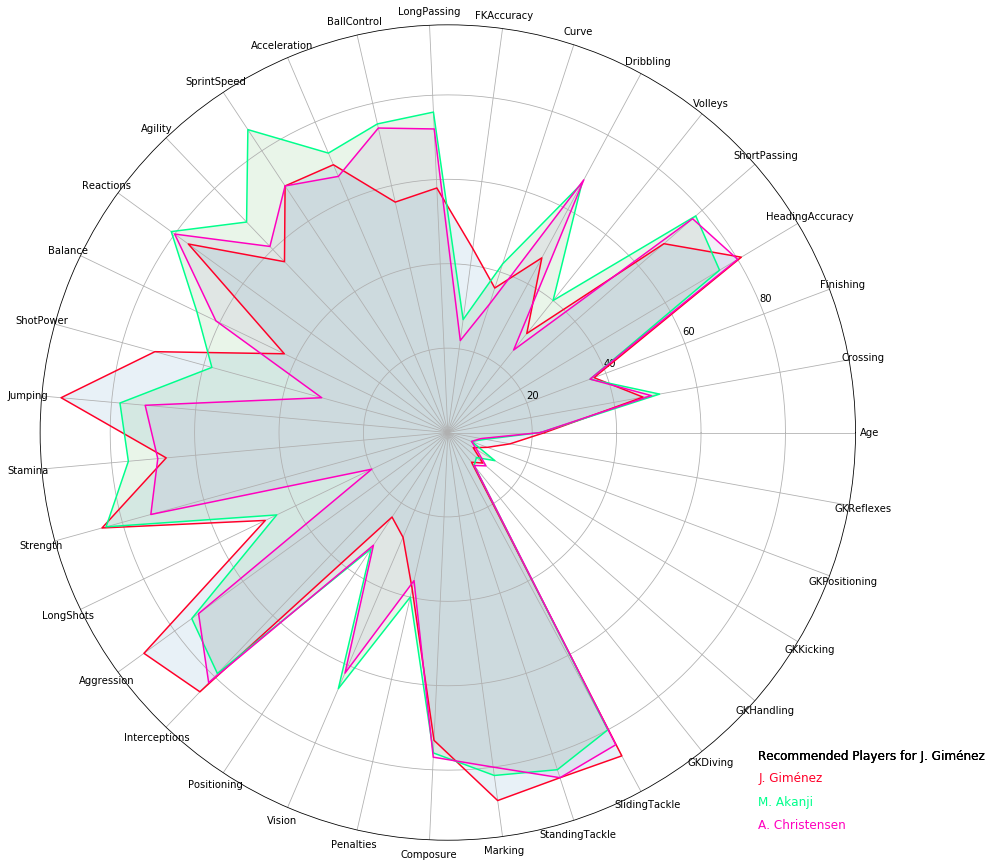

In [60]:
SkillChart(graph= standard_player, 
           abilities = rador_variables, 
           player_name = pd.Series(standard_player.index).values)

### NECESSARY FILES DUMPED TO PICKLE FORMAT FOR BID PREDICTION

In [61]:
print(display_df.shape)
display_df.head()

(3, 98)


,ID,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Body Type,Real Face,Position,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause,Club_Reputation,Attack_WR,Defense_WR,Position_Group,Position_Potential,Attacking,Skill,Movement,Power,Mentality,Defending,GoalKeeping,Potential_Difference,Continent
111,111,J. Giménez,23,Uruguay,84,88,Atlético Madrid,34000000.0,63000.0,1758,1,2.0,3.0,2.0,Normal,1,RCB,24.0,2010.0,0,5.0,185,176.0,56,56,56,51,51,51,51,51,50,50,50,53,56,56,56,53,71,73,73,73,71,74,83,83,83,74,47.0,37.0,81.0,68.0,30.0,47.0,36.0,44.0,58.0,56.0,69.0,70.0,56.0,76.0,43.0,72.0,92.0,67.0,85.0,48.0,89.0,85.0,24.0,27.0,38.0,73.0,88.0,86.0,87.0,9.0,11.0,7.0,10.0,15.0,72300000.0,1.878788,Medium,High,Defender,2,52.6,48.2,62.8,72.8,56.000000,87.000000,10.4,4,South America
322,322,M. Akanji,22,Switzerland,81,87,Borussia Dortmund,21000000.0,49000.0,1868,1,2.0,3.0,2.0,Normal,0,LCB,5.0,351.0,0,4.0,188,187.0,60,60,60,63,62,62,62,63,65,65,65,66,70,70,70,66,75,78,78,78,75,76,80,80,80,76,51.0,36.0,75.0,78.0,40.0,67.0,42.0,27.0,76.0,75.0,72.0,86.0,69.0,81.0,66.0,58.0,78.0,76.0,84.0,45.0,75.0,79.0,33.0,66.0,40.0,76.0,82.0,84.0,80.0,10.0,9.0,13.0,6.0,9.0,39900000.0,2.000000,Medium,High,Defender,2,56.0,57.4,74.8,68.2,61.500000,82.000000,9.4,6,Europe
336,336,A. Christensen,22,Denmark,81,88,Chelsea,21500000.0,91000.0,1717,1,2.0,3.0,2.0,Lean,1,LCB,6.0,2092.0,0,4.0,188,179.0,55,55,55,59,58,58,58,59,62,62,62,63,68,68,68,63,73,77,77,77,73,75,79,79,79,75,49.0,36.0,80.0,77.0,25.0,68.0,32.0,22.0,72.0,74.0,66.0,70.0,61.0,80.0,61.0,31.0,72.0,69.0,73.0,20.0,73.0,82.0,32.0,62.0,36.0,77.0,80.0,86.0,84.0,10.0,12.0,8.0,6.0,8.0,44100000.0,2.121212,Low,Medium,Defender,2,53.4,53.6,67.6,53.0,60.333333,83.333333,8.8,7,Europe


In [62]:
print(display_df1.shape)
display_df1.head()

(3, 81)


,Age,Overall,Potential,Special,International Reputation,Weak Foot,Skill Moves,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Club_Reputation,Position_Potential,Attacking,Skill,Movement,Power,Mentality,Defending,GoalKeeping,Potential_Difference,Attack_WR,Defense_WR
111,-0.454460,2.567112,2.719301,0.586745,2.250592,0.079797,-0.477831,0.570870,0.642655,0.231612,0.231612,0.231612,-0.067970,-0.054677,-0.054677,-0.054677,-0.067970,-0.114016,-0.114016,-0.114016,-0.001634,0.213898,0.213898,0.213898,-0.001634,0.996121,1.111485,1.111485,1.111485,0.996121,1.175664,1.622210,1.622210,1.622210,1.175664,-0.148888,-0.437940,1.651484,0.633596,-0.729574,-0.442679,-0.607283,0.065043,0.345006,-0.142002,0.293818,0.359945,-0.508180,1.571926,-1.483228,0.959534,2.276752,0.237824,1.567936,0.046211,1.907645,1.850652,-1.329261,-1.866251,-0.671730,1.254980,2.045754,1.768058,1.941822,-0.430420,-0.318908,-0.559437,-0.375063,-0.095289,3.420837,0.316222,0.186069,-0.195144,-0.083090,1.224679,0.312141,1.963188,-0.356921,-0.197360,-0.418496,1.817483
322,-0.668573,2.133236,2.556282,0.989889,2.250592,0.079797,-0.477831,1.019186,1.348104,0.429993,0.429993,0.429993,0.508429,0.476407,0.476407,0.476407,0.508429,0.608628,0.608628,0.608628,0.624534,0.908678,0.908678,0.908678,0.624534,1.195961,1.357942,1.357942,1.357942,1.195961,1.275442,1.477473,1.477473,1.477473,1.275442,0.068929,-0.489156,1.306249,1.313910,-0.164408,0.614970,-0.281103,-0.907592,1.519370,0.996668,0.494791,1.452129,0.372242,2.126851,0.143850,0.147351,1.092291,0.804065,1.488297,-0.109552,1.101541,1.560746,-0.868396,0.890616,-0.544371,1.517314,1.744305,1.675737,1.613006,-0.373906,-0.437206,-0.195854,-0.609885,-0.429465,3.962458,0.316222,0.414936,0.384503,0.989541,0.809281,0.762413,1.718522,-0.415742,0.171806,-0.418496,1.817483
336,-0.668573,2.133236,2.719301,0.436481,2.250592,0.079797,-0.477831,1.019186,0.835050,0.182016,0.182016,0.182016,0.316296,0.283285,0.283285,0.283285,0.316296,0.464099,0.464099,0.464099,0.480034,0.809424,0.809424,0.809424,0.480034,1.096041,1.308650,1.308650,1.308650,1.096041,1.225553,1.429227,1.429227,1.429227,1.225553,-0.039979,-0.489156,1.593945,1.245879,-1.012157,0.667853,-0.824736,-1.193662,1.258400,0.936738,0.092845,0.359945,-0.169556,2.015866,-0.209863,-1.419003,0.584664,0.363656,0.612268,-1.407580,0.986384,1.705699,-0.919604,0.607861,-0.799089,1.604759,1.643822,1.768058,1.800901,-0.373906,-0.259759,-0.498840,-0.609885,-0.485161,4.504080,0.316222,0.239920,0.145084,0.345962,-0.563342,0.666900,1.783766,-0.451035,0.356389,-2.335133,-0.170930


In [63]:
print(playrpredictorss.shape)
playrpredictorss.head()

(3, 125)


,Age,Overall,Potential,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Real Face,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Club_Reputation,Position_Potential,Attacking,Skill,Movement,Power,Mentality,Defending,GoalKeeping,Potential_Difference,Body Type,Attack_WR,Defense_WR,Position_CAM,Position_CB,Position_CDM,Position_CF,Position_CM,Position_GK,Position_LAM,Position_LB,Position_LCB,Position_LCM,Position_LDM,Position_LF,Position_LM,Position_LS,Position_LW,Position_LWB,Position_RAM,Position_RB,Position_RCB,Position_RCM,Position_RDM,Position_RF,Position_RM,Position_RS,Position_RW,Position_RWB,Position_ST,Continent_Africa,Continent_Asia,Continent_Europe,Continent_North America,Continent_Oceania,Continent_South America,Position_Group_Defender,Position_Group_Forward,Position_Group_GoalKeeper,Position_Group_Midfielder
111,23,84,88,1758,1,2.0,3.0,2.0,1,24.0,2010.0,0,5.0,185,176.0,56,56,56,51,51,51,51,51,50,50,50,53,56,56,56,53,71,73,73,73,71,74,83,83,83,74,47.0,37.0,81.0,68.0,30.0,47.0,36.0,44.0,58.0,56.0,69.0,70.0,56.0,76.0,43.0,72.0,92.0,67.0,85.0,48.0,89.0,85.0,24.0,27.0,38.0,73.0,88.0,86.0,87.0,9.0,11.0,7.0,10.0,15.0,1.878788,2,52.6,48.2,62.8,72.8,56.000000,87.000000,10.4,4,2,2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
322,22,81,87,1868,1,2.0,3.0,2.0,0,5.0,351.0,0,4.0,188,187.0,60,60,60,63,62,62,62,63,65,65,65,66,70,70,70,66,75,78,78,78,75,76,80,80,80,76,51.0,36.0,75.0,78.0,40.0,67.0,42.0,27.0,76.0,75.0,72.0,86.0,69.0,81.0,66.0,58.0,78.0,76.0,84.0,45.0,75.0,79.0,33.0,66.0,40.0,76.0,82.0,84.0,80.0,10.0,9.0,13.0,6.0,9.0,2.000000,2,56.0,57.4,74.8,68.2,61.500000,82.000000,9.4,6,2,2,3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
336,22,81,88,1717,1,2.0,3.0,2.0,1,6.0,2092.0,0,4.0,188,179.0,55,55,55,59,58,58,58,59,62,62,62,63,68,68,68,63,73,77,77,77,73,75,79,79,79,75,49.0,36.0,80.0,77.0,25.0,68.0,32.0,22.0,72.0,74.0,66.0,70.0,61.0,80.0,61.0,31.0,72.0,69.0,73.0,20.0,73.0,82.0,32.0,62.0,36.0,77.0,80.0,86.0,84.0,10.0,12.0,8.0,6.0,8.0,2.121212,2,53.4,53.6,67.6,53.0,60.333333,83.333333,8.8,7,1,1,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0


In [64]:
print(display_df2.shape)
display_df2.head()

(3, 131)


,ID,Name,Nationality,Club,Position,Age,Overall,Potential,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Real Face,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Club_Reputation,Position_Potential,Attacking,Skill,Movement,Power,Mentality,Defending,GoalKeeping,Potential_Difference,Body Type,Attack_WR,Defense_WR,Position_CAM,Position_CB,Position_CDM,Position_CF,Position_CM,Position_GK,Position_LAM,Position_LB,Position_LCB,Position_LCM,Position_LDM,Position_LF,Position_LM,Position_LS,Position_LW,Position_LWB,Position_RAM,Position_RB,Position_RCB,Position_RCM,Position_RDM,Position_RF,Position_RM,Position_RS,Position_RW,Position_RWB,Position_ST,Continent_Africa,Continent_Asia,Continent_Europe,Continent_North America,Continent_Oceania,Continent_South America,Position_Group_Defender,Position_Group_Forward,Position_Group_GoalKeeper,Position_Group_Midfielder,position_group
111,111,J. Giménez,Uruguay,Atlético Madrid,RCB,23,84,88,1758,1,2.0,3.0,2.0,1,24.0,2010.0,0,5.0,185,176.0,56,56,56,51,51,51,51,51,50,50,50,53,56,56,56,53,71,73,73,73,71,74,83,83,83,74,47.0,37.0,81.0,68.0,30.0,47.0,36.0,44.0,58.0,56.0,69.0,70.0,56.0,76.0,43.0,72.0,92.0,67.0,85.0,48.0,89.0,85.0,24.0,27.0,38.0,73.0,88.0,86.0,87.0,9.0,11.0,7.0,10.0,15.0,1.878788,2,52.6,48.2,62.8,72.8,56.000000,87.000000,10.4,4,2,2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,cent_df
322,322,M. Akanji,Switzerland,Borussia Dortmund,LCB,22,81,87,1868,1,2.0,3.0,2.0,0,5.0,351.0,0,4.0,188,187.0,60,60,60,63,62,62,62,63,65,65,65,66,70,70,70,66,75,78,78,78,75,76,80,80,80,76,51.0,36.0,75.0,78.0,40.0,67.0,42.0,27.0,76.0,75.0,72.0,86.0,69.0,81.0,66.0,58.0,78.0,76.0,84.0,45.0,75.0,79.0,33.0,66.0,40.0,76.0,82.0,84.0,80.0,10.0,9.0,13.0,6.0,9.0,2.000000,2,56.0,57.4,74.8,68.2,61.500000,82.000000,9.4,6,2,2,3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,cent_df
336,336,A. Christensen,Denmark,Chelsea,LCB,22,81,88,1717,1,2.0,3.0,2.0,1,6.0,2092.0,0,4.0,188,179.0,55,55,55,59,58,58,58,59,62,62,62,63,68,68,68,63,73,77,77,77,73,75,79,79,79,75,49.0,36.0,80.0,77.0,25.0,68.0,32.0,22.0,72.0,74.0,66.0,70.0,61.0,80.0,61.0,31.0,72.0,69.0,73.0,20.0,73.0,82.0,32.0,62.0,36.0,77.0,80.0,86.0,84.0,10.0,12.0,8.0,6.0,8.0,2.121212,2,53.4,53.6,67.6,53.0,60.333333,83.333333,8.8,7,1,1,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,cent_df


In [65]:
print(fifa.shape)
fifa.head()

(18159, 98)


,ID,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Body Type,Real Face,Position,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause,Club_Reputation,Attack_WR,Defense_WR,Position_Group,Position_Potential,Attacking,Skill,Movement,Power,Mentality,Defending,GoalKeeping,Potential_Difference,Continent
0,0,L. Messi,31,Argentina,94,94,FC Barcelona,110500000.0,565000.0,2202,0,5.0,4.0,4.0,Lean,1,RF,10.0,5297.0,0,3.0,170,159.0,88,88,88,92,93,93,93,92,93,93,93,91,84,84,84,91,64,61,61,61,64,59,47,47,47,59,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,226500000.0,2.242424,Medium,Medium,Forward,2,85.0,93.4,91.6,75.6,71.500000,29.000000,10.8,0,South America
1,1,Cristiano Ronaldo,33,Portugal,94,94,Juventus,77000000.0,405000.0,2228,1,5.0,4.0,5.0,Normal,1,ST,7.0,175.0,0,4.0,188,183.0,91,91,91,89,90,90,90,89,88,88,88,88,81,81,81,88,65,61,61,61,65,61,53,53,53,61,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,127100000.0,2.520000,High,Low,Forward,3,87.0,83.2,86.6,90.0,74.833333,27.333333,11.6,0,Europe
2,2,Neymar Jr,26,Brazil,92,93,Paris Saint-Germain,118500000.0,290000.0,2143,1,5.0,5.0,5.0,Lean,1,LW,10.0,516.0,0,4.0,175,150.0,84,84,84,89,89,89,89,89,89,89,89,88,81,81,81,88,65,60,60,60,65,60,47,47,47,60,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,228100000.0,2.233333,High,Medium,Forward,3,79.2,88.8,91.6,70.6,73.833333,28.000000,11.8,1,South America
3,3,De Gea,27,Spain,91,93,Manchester United,72000000.0,260000.0,1471,1,4.0,3.0,1.0,Lean,1,GK,1.0,2741.0,0,2.0,193,168.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,138600000.0,2.090909,Medium,Medium,GoalKeeper,0,22.8,30.2,61.6,43.4,42.666667,16.333333,88.8,2,Europe
4,4,K. De Bruyne,27,Belgium,91,92,Manchester City,102000000.0,355000.0,2281,1,4.0,5.0,4.0,Normal,1,RCM,7.0,1220.0,0,5.0,180,154.0,82,82,82,87,87,87,87,87,88,88,88,88,87,87,87,88,77,77,77,77,77,73,66,66,66,73,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,196400000.0,2.090909,High,High,Midfielder,3,80.8,87.2,80.2,82.0,80.833333,59.000000,11.2,1,Europe


In [66]:
print(predictors_df.shape)
predictors_df.head()

(18159, 125)


,Age,Overall,Potential,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Real Face,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Club_Reputation,Position_Potential,Attacking,Skill,Movement,Power,Mentality,Defending,GoalKeeping,Potential_Difference,Body Type,Attack_WR,Defense_WR,Position_CAM,Position_CB,Position_CDM,Position_CF,Position_CM,Position_GK,Position_LAM,Position_LB,Position_LCB,Position_LCM,Position_LDM,Position_LF,Position_LM,Position_LS,Position_LW,Position_LWB,Position_RAM,Position_RB,Position_RCB,Position_RCM,Position_RDM,Position_RF,Position_RM,Position_RS,Position_RW,Position_RWB,Position_ST,Continent_Africa,Continent_Asia,Continent_Europe,Continent_North America,Continent_Oceania,Continent_South America,Position_Group_Defender,Position_Group_Forward,Position_Group_GoalKeeper,Position_Group_Midfielder
0,31,94,94,2202,0,5.0,4.0,4.0,1,10.0,5297.0,0,3.0,170,159.0,88,88,88,92,93,93,93,92,93,93,93,91,84,84,84,91,64,61,61,61,64,59,47,47,47,59,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,2.242424,2,85.0,93.4,91.6,75.6,71.500000,29.000000,10.8,0,1,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
1,33,94,94,2228,1,5.0,4.0,5.0,1,7.0,175.0,0,4.0,188,183.0,91,91,91,89,90,90,90,89,88,88,88,88,81,81,81,88,65,61,61,61,65,61,53,53,53,61,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,2.520000,3,87.0,83.2,86.6,90.0,74.833333,27.333333,11.6,0,2,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0
2,26,92,93,2143,1,5.0,5.0,5.0,1,10.0,516.0,0,4.0,175,150.0,84,84,84,89,89,89,89,89,89,89,89,88,81,81,81,88,65,60,60,60,65,60,47,47,47,60,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,2.233333,3,79.2,88.8,91.6,70.6,73.833333,28.000000,11.8,1,1,3,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
3,27,91,93,1471,1,4.0,3.0,1.0,1,1.0,2741.0,0,2.0,193,168.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,2.090909,0,22.8,30.2,61.6,43.4,42.666667,16.333333,88.8,2,1,2,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4,27,91,92,2281,1,4.0,5.0,4.0,1,7.0,1220.0,0,5.0,180,154.0,82,82,82,87,87,87,87,87,88,88,88,88,87,87,87,88,77,77,77,77,77,73,66,66,66,73,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,2.090909,3,80.8,87.2,80.2,82.0,80.833333,59.000000,11.2,1,2,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


In [67]:
print(df3.shape)
df3.head()

(18159, 131)


,ID,Name,Nationality,Club,Position,Age,Overall,Potential,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Real Face,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Club_Reputation,Position_Potential,Attacking,Skill,Movement,Power,Mentality,Defending,GoalKeeping,Potential_Difference,Body Type,Attack_WR,Defense_WR,Position_CAM,Position_CB,Position_CDM,Position_CF,Position_CM,Position_GK,Position_LAM,Position_LB,Position_LCB,Position_LCM,Position_LDM,Position_LF,Position_LM,Position_LS,Position_LW,Position_LWB,Position_RAM,Position_RB,Position_RCB,Position_RCM,Position_RDM,Position_RF,Position_RM,Position_RS,Position_RW,Position_RWB,Position_ST,Continent_Africa,Continent_Asia,Continent_Europe,Continent_North America,Continent_Oceania,Continent_South America,Position_Group_Defender,Position_Group_Forward,Position_Group_GoalKeeper,Position_Group_Midfielder,position_group
0,0,L. Messi,Argentina,FC Barcelona,RF,31,94,94,2202,0,5.0,4.0,4.0,1,10.0,5297.0,0,3.0,170,159.0,88,88,88,92,93,93,93,92,93,93,93,91,84,84,84,91,64,61,61,61,64,59,47,47,47,59,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,2.242424,2,85.0,93.4,91.6,75.6,71.500000,29.000000,10.8,0,1,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,side_fw
1,1,Cristiano Ronaldo,Portugal,Juventus,ST,33,94,94,2228,1,5.0,4.0,5.0,1,7.0,175.0,0,4.0,188,183.0,91,91,91,89,90,90,90,89,88,88,88,88,81,81,81,88,65,61,61,61,65,61,53,53,53,61,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,2.520000,3,87.0,83.2,86.6,90.0,74.833333,27.333333,11.6,0,2,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,cent_fw
2,2,Neymar Jr,Brazil,Paris Saint-Germain,LW,26,92,93,2143,1,5.0,5.0,5.0,1,10.0,516.0,0,4.0,175,150.0,84,84,84,89,89,89,89,89,89,89,89,88,81,81,81,88,65,60,60,60,65,60,47,47,47,60,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,2.233333,3,79.2,88.8,91.6,70.6,73.833333,28.000000,11.8,1,1,3,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,side_fw
3,3,De Gea,Spain,Manchester United,GK,27,91,93,1471,1,4.0,3.0,1.0,1,1.0,2741.0,0,2.0,193,168.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,2.090909,0,22.8,30.2,61.6,43.4,42.666667,16.333333,88.8,2,1,2,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,goalkeep
4,4,K. De Bruyne,Belgium,Manchester City,RCM,27,91,92,2281,1,4.0,5.0,4.0,1,7.0,1220.0,0,5.0,180,154.0,82,82,82,87,87,87,87,87,88,88,88,88,87,87,87,88,77,77,77,77,77,73,66,66,66,73,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,2.090909,3,80.8,87.2,80.2,82.0,80.833333,59.000000,11.2,1,2,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,cent_md


In [68]:
with open('df3scaled.pkl', 'wb') as f:
    pickle.dump(df3scaled, f)

In [69]:
with open('undervalue_players.pkl', 'wb') as f:
    pickle.dump(display_df, f)

In [70]:
with open('undervalue_players1.pkl', 'wb') as f:
    pickle.dump(display_df1, f)

In [71]:
with open('undervalue_players2.pkl', 'wb') as f:
    pickle.dump(display_df2, f)

In [72]:
with open('newfifa.pkl', 'wb') as f:
    pickle.dump(fifa, f)

In [73]:
with open('newpredictors.pkl', 'wb') as f:
    pickle.dump(predictors_df, f)

In [74]:
with open('nnewdf3.pkl', 'wb') as f:
    pickle.dump(df3, f)

In [75]:
with open('finalpred.pkl', 'wb') as f:
    pickle.dump(playrpredictorss, f)

In [76]:
with open('predictorsscale.pkl', 'wb') as f:
    pickle.dump(predictors_scaled, f)